In [1]:
# libraries
import numpy as np
import copy
import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
MNIST_trainset = datasets.MNIST(root='data/', train=True, download=True,
                                transform=transforms.ToTensor())
MNIST_testset = datasets.MNIST(root='data/', train=False, download=True,
                               transform=transforms.ToTensor())

In [3]:
class SubDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, sub_labels, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.sub_indeces = []
        for index in range(len(self.dataset)):
            label = self.dataset.targets[index]
            if label in sub_labels:
                self.sub_indeces.append(index)
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sub_indeces)

    def __getitem__(self, index):
        sample = self.dataset[self.sub_indeces[index]]
        if self.target_transform:
            target = self.target_transform(sample[1])
            sample = (sample[0], target)
        return sample

In [4]:
# Configuration
iters = 200      
lr = 0.01         
batch_size = 128 
ewc_lambda = 100
tasks = 5
classes_per_task = 2

In [5]:
# Generate Split MNIST-dataset 
labels_per_task = [
    list(np.array(range(classes_per_task))+classes_per_task*task_id) for task_id in range(tasks)
]

train_datasets = []
test_datasets = []
for labels in labels_per_task:
    train_datasets.append(SubDataset(MNIST_trainset, labels))
    test_datasets.append(SubDataset(MNIST_testset, labels))

In [6]:
# Helper function
## Define plot function
def plot_examples(axis, dataset, task_id=None):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)
    image_tensor, _ = next(iter(data_loader))
    image_grid = make_grid(image_tensor, nrow=5, pad_value=1)
    axis.imshow(np.transpose(image_grid.numpy(), (1,2,0)))
    if task_id is not None:
        axis.set_title("Task {}".format(task_id+1))
    axis.axis('off')

## Define a function to initiate a dict-object in which performance throughout training is logged.
def initiate_result_dict(n_tasks):
    '''Initiate <dict> with accuracy-measures to keep track of.'''
    result_dict = {}
    result_dict["acc per task"] = {}
    for i in range(n_tasks):
        result_dict["acc per task"]["task {}".format(i+1)] = []
    result_dict["average_tasks_so_far"] = []  # average accuracy over all tasks so far
    result_dict["average_all_tasks"] = []     # average accuracy over all tasks
    result_dict["task"] = []                  # number of tasks so far
    return result_dict

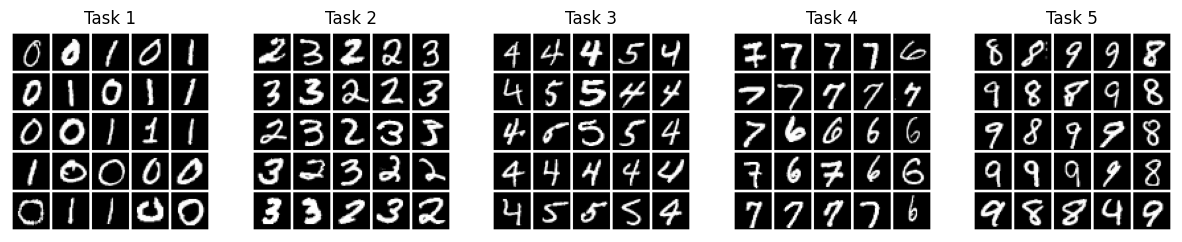

In [7]:
# Visualize the tasks
figure, axis = plt.subplots(1, tasks, figsize=(3*tasks, 4))

for task_id in range(len(train_datasets)):
    plot_examples(axis[task_id], train_datasets[task_id], task_id=task_id)

In [8]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.output_layers  = nn.Linear(40, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))      
        x = self.output_layers(x)
        return x

In [9]:
model = SimpleNN()

model

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=40, bias=True)
  (output_layers): Linear(in_features=40, out_features=10, bias=True)
)

In [10]:
def apply_mask(outputs, task_id):
    mask = torch.ones_like(outputs)
    mask[:, :2*task_id] = 0 
    mask[:, 2*(task_id+1):] = 0 
    return outputs * mask

In [11]:
def estimate_fisher(model, dataset, n_samples, ewc_gamma=1.):

    est_fisher_info = {}
    for n, p in model.named_parameters():
        n = n.replace('.', '__')
        est_fisher_info[n] = p.detach().clone().zero_()

    mode = model.training
    model.eval()

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

    for index,(x,y) in enumerate(data_loader):
        # break from for-loop if max number of samples has been reached
        if n_samples is not None:
            if index > n_samples:
                break
        output = model(x)
        with torch.no_grad():
            label_weights = F.softmax(output, dim=1)         
        for label_index in range(output.shape[1]):
            label = torch.LongTensor([label_index])
            negloglikelihood = F.cross_entropy(output, label)
            model.zero_grad()
            negloglikelihood.backward(retain_graph=True if (label_index+1)<output.shape[1] else False)
            for n, p in model.named_parameters():
                n = n.replace('.', '__')
                if p.grad is not None:
                    est_fisher_info[n] += label_weights[0][label_index] * (p.grad.detach() ** 2)

    est_fisher_info = {n: p/index for n, p in est_fisher_info.items()}

    for n, p in model.named_parameters():
        n = n.replace('.', '__')
        model.register_buffer('{}_EWC_param_values'.format(n,), p.detach().clone())
        if hasattr(model, '{}_EWC_estimated_fisher'.format(n)):
            existing_values = getattr(model, '{}_EWC_estimated_fisher'.format(n))
            est_fisher_info[n] += ewc_gamma * existing_values
        model.register_buffer('{}_EWC_estimated_fisher'.format(n), est_fisher_info[n])

    model.train(mode=mode)

In [12]:
def train_ewc(model, dataset, iters, lr, batch_size, current_task=None, ewc_lambda=100., task_id=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    progress_bar = tqdm.tqdm(range(1, iters + 1))

    for batch_index in range(1, iters + 1):
        iters_left -= 1
        if iters_left == 0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        optimizer.zero_grad()
        y_hat = model(x)
        
        if task_id is not None:
            # mask irrelevant output, for example task_id = 1 -> classes 2 and 3 are left active 
            masked_outputs = apply_mask(y_hat, task_id)
            # adjust the orginial labels from 2 and 3 to adjusted labels of 0 and 1
            adjusted_labels = y - 2 * task_id          
            loss = torch.nn.functional.cross_entropy(input=masked_outputs[:, 2*task_id:2*(task_id+1)], 
                                                     target=adjusted_labels)
            # Calculate training-accuracy (in %) based on the active outputs
            _, predicted = torch.max(masked_outputs[:, 2*task_id:2*(task_id+1)], 1)
            accuracy = (predicted == adjusted_labels).sum().item() * 100 / x.size(0)
        else:
            # Calculate prediction loss for the full 10-class output layer
            loss = torch.nn.functional.cross_entropy(input=y_hat, target=y)
            # Calculate training-accuracy (in %)
            accuracy = (y == y_hat.max(1)[1]).sum().item() * 100 / x.size(0)

        # Compute the EWC-regularization term, and add it to the loss (except if first task)
        if current_task is not None and current_task > 1:
            ewc_losses = []
            for n, p in model.named_parameters():
                # Retrieve stored mode (MAP estimate) and precision (Fisher Information matrix)
                n = n.replace('.', '__')
                mean = getattr(model, '{}_EWC_param_values'.format(n))
                fisher = getattr(model, '{}_EWC_estimated_fisher'.format(n))
                # Calculate weight regularization loss
                ewc_losses.append((fisher * (p - mean)**2).sum())
            ewc_loss = (1./2) * sum(ewc_losses)
            total_loss = loss + ewc_lambda * ewc_loss
        else:
            total_loss = loss

        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
            '<CLASSIFIER> | training loss: {loss:.3f} | training accuracy: {prec:.3f}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()


In [13]:
def test_acc(model, dataset, task_id=None, test_size=None, batch_size=128):
    mode = model.training
    model.eval()

    # Loop over batches in [dataset]
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              shuffle=True, drop_last=False)
    total_tested = total_correct = 0
    for x, y in data_loader:
        # -break on [test_size] (if "None", full dataset is used)
        if test_size:
            if total_tested >= test_size:
                break
        with torch.no_grad():
            scores = model(x)
        
        if task_id is not None:
            # Apply mask to inactivate irrelevant outputs
            masked_outputs = apply_mask(scores, task_id)
            # Adjust labels to range [0, 1] for this task
            adjusted_labels = y - 2 * task_id
            # Evaluate predictions on the active outputs
            _, predicted = torch.max(masked_outputs[:, 2*task_id:2*(task_id+1)], 1)
            # Update statistics
            total_correct += (predicted == adjusted_labels).sum().item()
        else:
            # Evaluate predictions using the full 10-class output layer
            _, predicted = torch.max(scores, 1)
            # Update statistics
            total_correct += (predicted == y).sum().item()
        
        total_tested += len(x)
    
    accuracy = total_correct * 100 / total_tested

    # Set model back to its initial mode and return accuracy
    model.train(mode=mode)

    return accuracy


In [14]:
def test_all(model, datasets, current_task, test_size=None, result_dict=None, verbose=False):
    '''Evaluate accuracy of a classifier (=[model]) on all tasks in [datasets].'''

    n_tasks = len(datasets)

    # Evaluate accuracy of model on all tasks
    precs = []
    for i in range(n_tasks):
        precs.append(test_acc(model, datasets[i], test_size=test_size))

    # Compute average accuracy both for all tasks seen so far, and for all tasks
    ave_so_far = sum([precs[task_id] for task_id in range(current_task)]) / current_task
    ave_all = sum([precs[task_id] for task_id in range(n_tasks)]) / n_tasks

    # Print results on screen
    if verbose:
        print(' => ave accuracy (tasks so far): {:.3f}'.format(ave_so_far))
        print(' => ave accuracy (all tasks):    {:.3f}'.format(ave_all))

    # Add results to [result_dict]
    if result_dict is not None:
        for i in range(n_tasks):
            result_dict['acc per task']['task {}'.format(i+1)].append(precs[i])
        result_dict['average_all_tasks'].append(ave_all)
        result_dict['average_tasks_so_far'].append(ave_so_far)
        result_dict['task'].append(current_task)

# Three  types of incremental learning

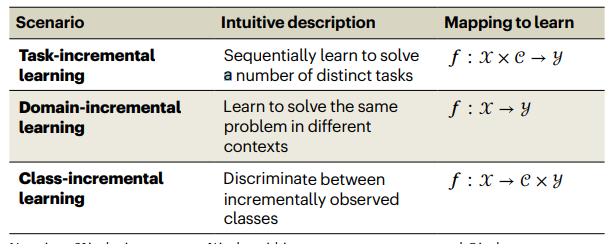

## Split MNIST

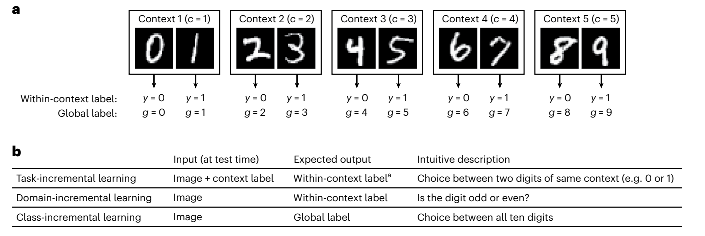

## Permute MNIST

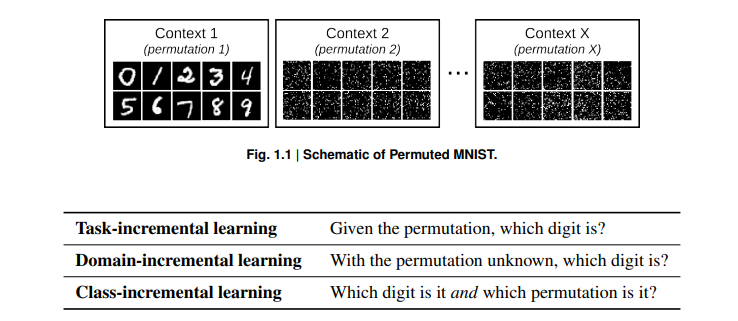

## Mixture of scenarios (Real-world continual learning assuming)

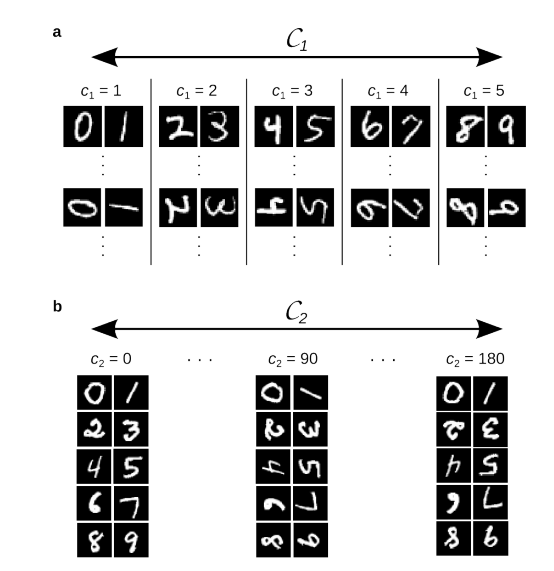

C1 : Split base on class label.  
C2 : Split base on rotation.

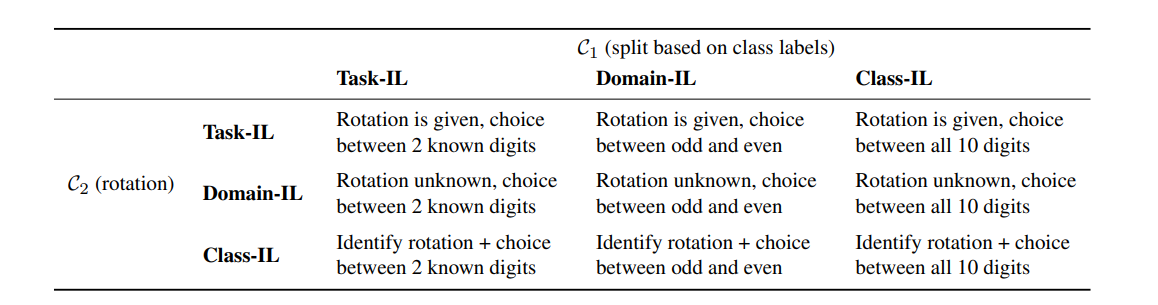

In [ ]:
model_normal_task = copy.deepcopy(model)
normal_task_accs = []
for task_id in range(tasks):
    train_ewc(model_normal_task, train_datasets[task_id], iters=iters, lr=lr, batch_size=batch_size, task_id=task_id)
    for i in range(tasks):
        if i > task_id: break
        acc = test_acc(model_normal_task, test_datasets[i], test_size=None, task_id=i)
        print(" - task {}: {:.1f}".format(i+1, acc))
        normal_task_accs.append(acc)

### Result of normal (baseline Strategy) Method on Task Incremental Learning

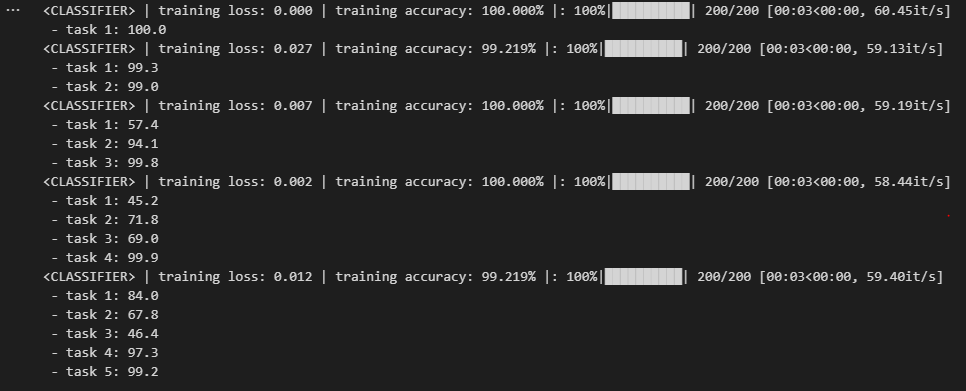

In [16]:
model_ewc_task = copy.deepcopy(model)
ewc_lambda = 100
ewc_task_accs = []
for task_id in range(tasks):
    train_ewc(model_ewc_task, train_datasets[task_id], iters=iters, lr=lr, batch_size=batch_size,
              current_task=task_id+1, ewc_lambda=ewc_lambda, task_id=task_id)
    estimate_fisher(model_ewc_task, train_datasets[task_id], n_samples=200)
    # Evaluate the performance of the model after training on this task
    for i in range(tasks):
        if i > task_id: break
        acc = test_acc(model_ewc_task, test_datasets[i], test_size=None, task_id=i)
        print(" - task {}: {:.1f}".format(i+1, acc))
        ewc_task_accs.append(acc)

<CLASSIFIER> | training loss: 0.002 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 52.71it/s]


 - task 1: 100.0


<CLASSIFIER> | training loss: 0.062 | training accuracy: 98.438% |: 100%|██████████| 200/200 [00:03<00:00, 56.87it/s] 


 - task 1: 78.4
 - task 2: 99.1


<CLASSIFIER> | training loss: 0.039 | training accuracy: 99.219% |: 100%|██████████| 200/200 [00:03<00:00, 56.00it/s] 


 - task 1: 60.4
 - task 2: 96.4
 - task 3: 99.4


<CLASSIFIER> | training loss: 0.007 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 57.40it/s]


 - task 1: 60.1
 - task 2: 92.3
 - task 3: 84.5
 - task 4: 99.3


<CLASSIFIER> | training loss: 0.208 | training accuracy: 97.656% |: 100%|██████████| 200/200 [00:03<00:00, 56.06it/s] 


 - task 1: 57.0
 - task 2: 88.3
 - task 3: 88.0
 - task 4: 99.3
 - task 5: 96.9


### Result of EWC Method on Task Incremental Learning

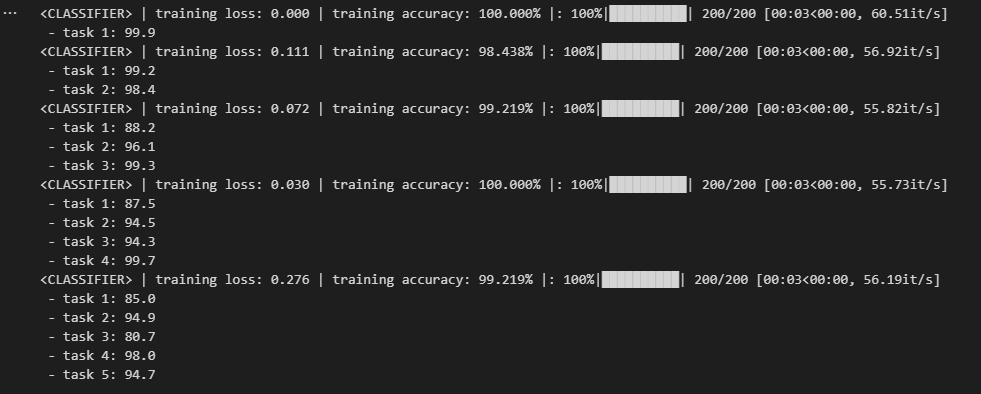

In [17]:
model_normal_domain = copy.deepcopy(model)
normal_task_accs = []
for task_id in range(tasks):
    train_ewc(model_normal_domain, train_datasets[task_id], iters=iters, lr=lr, batch_size=batch_size)
    for i in range(tasks):
        if i > task_id: break
        acc = test_acc(model_normal_domain, test_datasets[i], test_size=None, task_id=i)
        print(" - task {}: {:.1f}".format(i+1, acc))
        normal_task_accs.append(acc)

<CLASSIFIER> | training loss: 0.001 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 59.14it/s]


 - task 1: 100.0


<CLASSIFIER> | training loss: 0.010 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 61.09it/s]


 - task 1: 53.7
 - task 2: 98.3


<CLASSIFIER> | training loss: 0.016 | training accuracy: 99.219% |: 100%|██████████| 200/200 [00:03<00:00, 60.95it/s] 


 - task 1: 53.7
 - task 2: 50.5
 - task 3: 99.6


<CLASSIFIER> | training loss: 0.000 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 64.07it/s]


 - task 1: 46.3
 - task 2: 70.6
 - task 3: 47.6
 - task 4: 99.7


<CLASSIFIER> | training loss: 1.085 | training accuracy: 48.438% |: 100%|██████████| 200/200 [00:03<00:00, 63.77it/s]


 - task 1: 46.3
 - task 2: 49.5
 - task 3: 47.6
 - task 4: 51.8
 - task 5: 50.9


### Result of normal (baseline Strategy) Method on Domain Incremental Learning

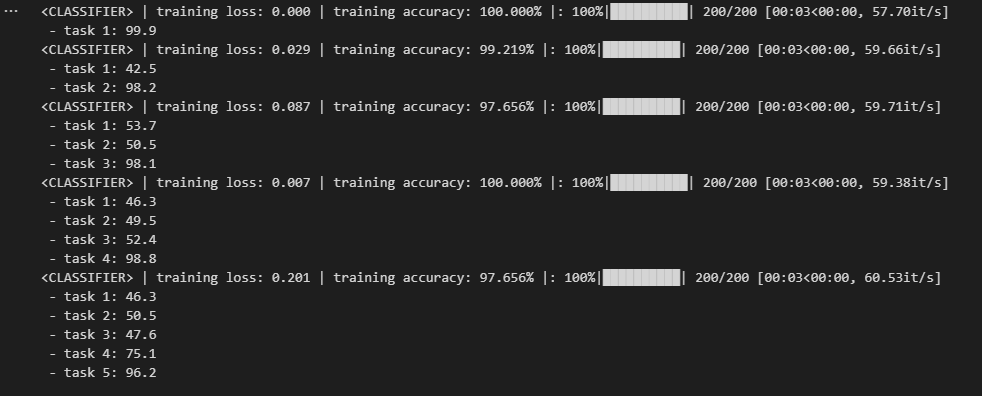

In [18]:
model_ewc_domain = copy.deepcopy(model)
ewc_task_accs = []
for task_id in range(tasks):
    train_ewc(model_ewc_domain, train_datasets[task_id], iters=iters, lr=lr, batch_size=batch_size,
              current_task=task_id+1, ewc_lambda=ewc_lambda)
    estimate_fisher(model_ewc_domain, train_datasets[task_id], n_samples=200)
    for i in range(tasks):
        if i > task_id: break
        acc = test_acc(model_ewc_domain, test_datasets[i], test_size=None, task_id=i)
        print(" - task {}: {:.1f}".format(i+1, acc))
        ewc_task_accs.append(acc)

<CLASSIFIER> | training loss: 0.000 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 62.87it/s]


 - task 1: 99.9


<CLASSIFIER> | training loss: 0.082 | training accuracy: 99.219% |: 100%|██████████| 200/200 [00:03<00:00, 58.15it/s] 


 - task 1: 73.4
 - task 2: 98.1


<CLASSIFIER> | training loss: 0.098 | training accuracy: 99.219% |: 100%|██████████| 200/200 [00:03<00:00, 59.26it/s] 


 - task 1: 26.1
 - task 2: 93.2
 - task 3: 99.4


<CLASSIFIER> | training loss: 0.039 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 60.68it/s]


 - task 1: 42.4
 - task 2: 50.7
 - task 3: 53.7
 - task 4: 99.0


<CLASSIFIER> | training loss: 0.100 | training accuracy: 99.219% |: 100%|██████████| 200/200 [00:03<00:00, 58.31it/s] 


 - task 1: 46.3
 - task 2: 50.5
 - task 3: 94.8
 - task 4: 52.9
 - task 5: 98.2


### Result of EWC Method on Domain Incremental Learning

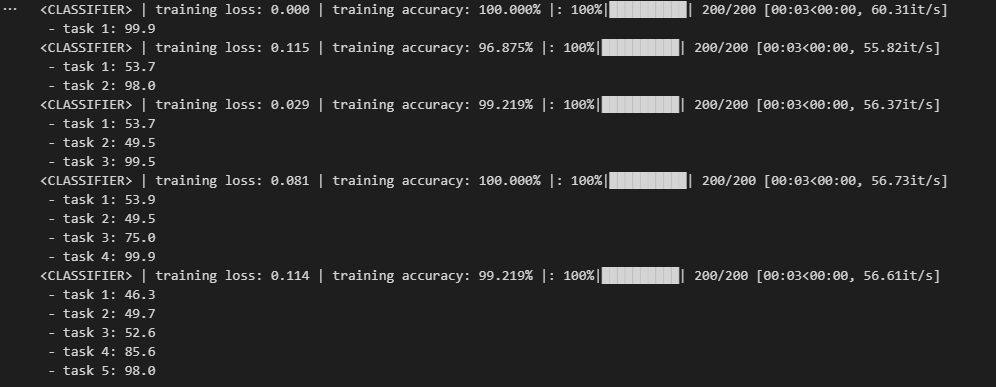


In [19]:
result_dict_normal = initiate_result_dict(tasks)
model_normal_class = copy.deepcopy(model)
normal_class_accs = []
for task_id in range(tasks):
    train_ewc(model=model_normal_class, dataset=train_datasets[task_id], iters=iters, lr=lr, batch_size=batch_size)
    acc = test_acc(model_normal_class, test_datasets[task_id], test_size=None)
    test_all(model_normal_class, test_datasets, task_id+1, test_size=None,
             result_dict=result_dict_normal, verbose=True)
    normal_class_accs.append(acc)

<CLASSIFIER> | training loss: 0.001 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 60.32it/s]


 => ave accuracy (tasks so far): 99.574
 => ave accuracy (all tasks):    19.915


<CLASSIFIER> | training loss: 0.061 | training accuracy: 97.656% |: 100%|██████████| 200/200 [00:03<00:00, 62.05it/s] 


 => ave accuracy (tasks so far): 49.021
 => ave accuracy (all tasks):    19.608


<CLASSIFIER> | training loss: 0.019 | training accuracy: 99.219% |: 100%|██████████| 200/200 [00:03<00:00, 57.85it/s] 


 => ave accuracy (tasks so far): 33.031
 => ave accuracy (all tasks):    19.819


<CLASSIFIER> | training loss: 0.018 | training accuracy: 99.219% |: 100%|██████████| 200/200 [00:03<00:00, 60.79it/s] 


 => ave accuracy (tasks so far): 24.887
 => ave accuracy (all tasks):    19.909


<CLASSIFIER> | training loss: 0.688 | training accuracy: 64.062% |: 100%|██████████| 200/200 [00:03<00:00, 59.60it/s]


 => ave accuracy (tasks so far): 9.823
 => ave accuracy (all tasks):    9.823


### Result of normal (baseline Strategy) Method on Class Incremental Learning

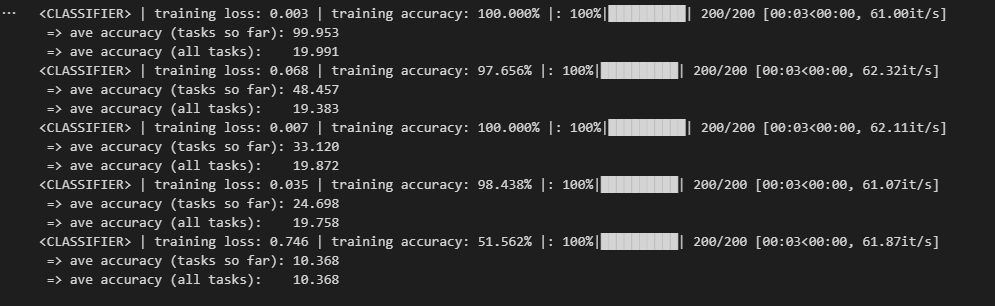

In [20]:
result_dict_ewc = initiate_result_dict(tasks)
model_ewc_class = copy.deepcopy(model)
ewc_lambda = 100
for task_id in range(tasks):
    # Train the model on this task
    train_ewc(model_ewc_class, train_datasets[task_id], iters=iters, lr=lr, batch_size=batch_size,
              current_task=task_id+1, ewc_lambda=ewc_lambda)
    # Estimate/update the FI-matrix (which is stored as attribute in the network)
    estimate_fisher(model_ewc_class, train_datasets[task_id], n_samples=200)
    # Evaluate the performance of the model after training on this task
    test_all(model_ewc_class, test_datasets, task_id+1, test_size=None,
             result_dict=result_dict_ewc, verbose=True)

<CLASSIFIER> | training loss: 0.001 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 58.05it/s]


 => ave accuracy (tasks so far): 99.953
 => ave accuracy (all tasks):    19.991


<CLASSIFIER> | training loss: 0.097 | training accuracy: 98.438% |: 100%|██████████| 200/200 [00:03<00:00, 57.51it/s]


 => ave accuracy (tasks so far): 48.825
 => ave accuracy (all tasks):    19.530


<CLASSIFIER> | training loss: 0.052 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 57.34it/s]


 => ave accuracy (tasks so far): 33.209
 => ave accuracy (all tasks):    19.925


<CLASSIFIER> | training loss: 0.035 | training accuracy: 100.000% |: 100%|██████████| 200/200 [00:03<00:00, 55.83it/s]


 => ave accuracy (tasks so far): 24.874
 => ave accuracy (all tasks):    19.899


<CLASSIFIER> | training loss: 0.135 | training accuracy: 96.875% |: 100%|██████████| 200/200 [00:03<00:00, 57.37it/s] 


 => ave accuracy (tasks so far): 19.735
 => ave accuracy (all tasks):    19.735


### Result of EWC Method on Class Incremental Learning
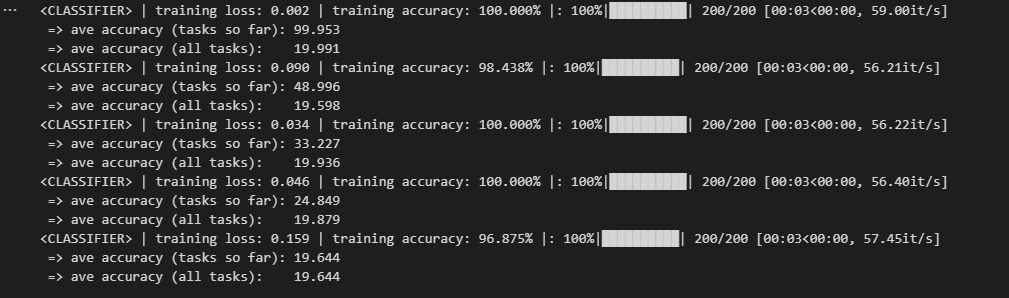

# Result on Split MNIST

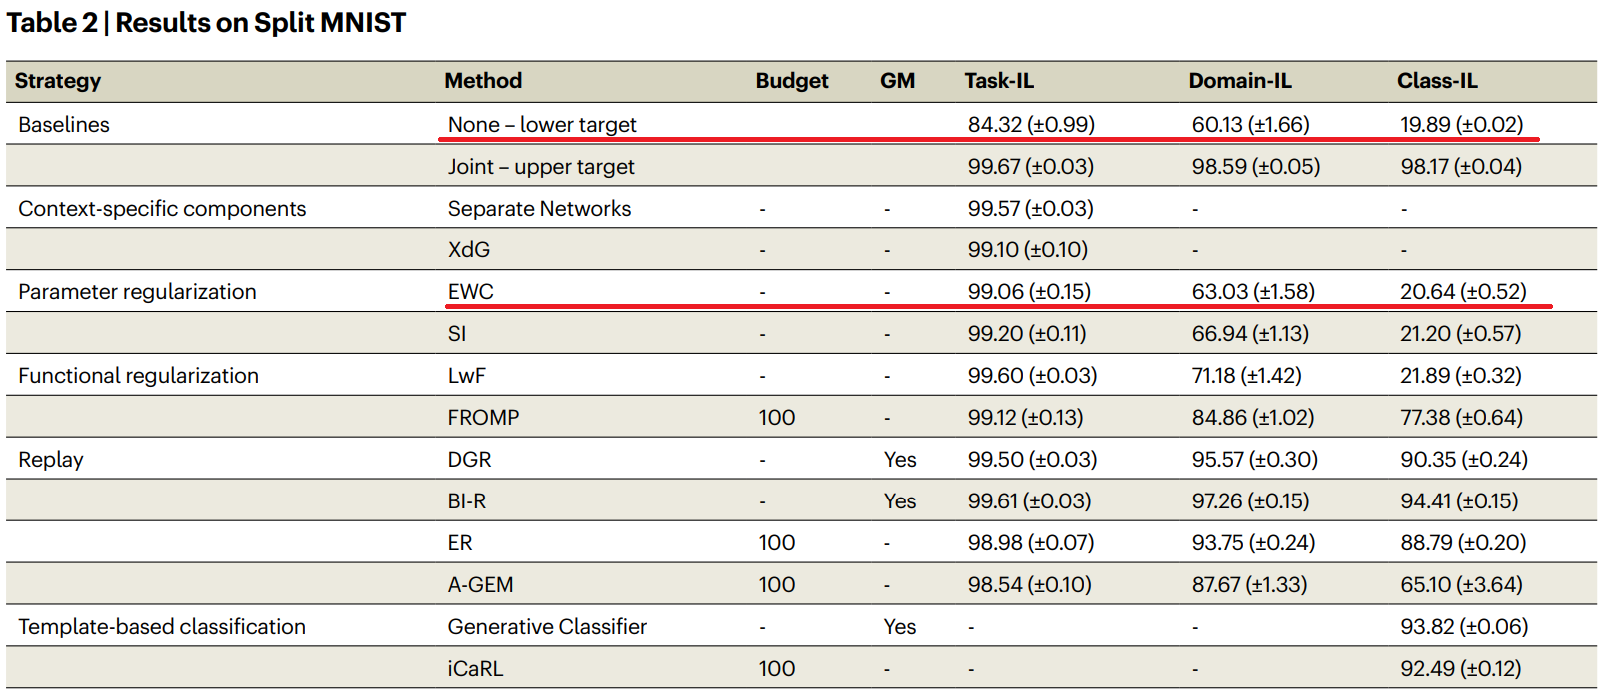